In [1]:
import pandas as pd
import numpy as np
import os

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets

# datasets = {dataset.name: dataset for dataset in datasets_list}

residual = True

num_epochs = 10
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001

In [2]:
name= "cic_ids_2017_5_percent"
# name= "cic_ton_iot_5_percent"
#name ='nf-bot-iot'
# name='nf-bot-iotv2'
#name ='edge-iiot'
#name ='cic-ids-2017'
#name ='cic-ton-iot'
#name ='nf-cse-cic-ids2018'
#name ='nf-uq-nids'
#name ='x-iiot'

#name ='cic-ton-iot-modified'
#name ='nf-ton-iotv2-modified'
#name ='ccd-inid-modified'
#name ='nf-uq-nids-modified'

dataset = datasets[name]

In [3]:
df = pd.read_parquet(dataset.path)

In [4]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack
66292,192.168.10.1-192.168.10.3-53-60671-17,192.168.10.3,60671.0,192.168.10.1,53.0,17.0,03/07/2017 10:23:37,30919.0,1.0,1.0,...,0.00000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN
244828,172.16.0.1-192.168.10.50-39546-80-6,172.16.0.1,39546.0,192.168.10.50,80.0,6.0,5/7/2017 10:55,0.0,2.0,0.0,...,0.00000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,1,DoS Hulk
420414,192.168.10.8-52.84.64.212-51938-443-6,52.84.64.212,443.0,192.168.10.8,51938.0,6.0,03/07/2017 11:20:18,3.0,1.0,1.0,...,0.00000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN
393869,172.217.10.2-192.168.10.8-80-55154-6,192.168.10.8,55154.0,172.217.10.2,80.0,6.0,5/7/2017 1:53,115525809.0,16.0,14.0,...,78974.81818,140027.3781,501173.0,36578.0,9976579.636,58066.24315,9994305.0,9801504.0,0,BENIGN
399570,None,None,NaN,None,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,None


In [5]:
df.Label.value_counts()

Label
0    113655
1     42313
Name: count, dtype: int64

In [6]:
df[dataset.src_ip_col] = df[dataset.src_ip_col].apply(str)
df[dataset.src_port_col] = df[dataset.src_port_col].apply(str)
df[dataset.dst_ip_col] = df[dataset.dst_ip_col].apply(str)
df[dataset.dst_port_col] = df[dataset.dst_port_col].apply(str)

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
y = df[dataset.label_col]
X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.3, random_state=13, stratify=y)

del df

In [10]:
X_train.shape

(98940, 84)

In [11]:
X_test.shape

(42403, 84)

In [12]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list([dataset.label_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))

In [13]:
scaler = StandardScaler()
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [14]:
G = nx.from_pandas_edgelist(X_train, dataset.src_ip_col, dataset.dst_ip_col, ['h',dataset.label_col], create_using=nx.MultiDiGraph())

In [ ]:
get netowrk properties

In [15]:
del X_train

G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [16]:
num_features = G.edata['h'].shape[1]

In [17]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [18]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [19]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [20]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [21]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata[dataset.label_col]
train_mask = G.edata['train_mask']

# model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
#                    dropout=0.2, num_neighbors=4, residual=residual)

model = EGCN(num_features, num_features, 128, F.relu,
                   dropout=0.2, residual=residual)

opt = th.optim.Adam(model.parameters())

In [22]:
for epoch in range(1,num_epochs):
#     pred = model(G, node_features,edge_features).cuda()
    pred = model(G, node_features,edge_features)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 1  Training acc: 0.3357388377189636
Epoch: 2  Training acc: 0.42341822385787964
Epoch: 3  Training acc: 0.5992621779441833
Epoch: 4  Training acc: 0.8197594285011292
Epoch: 5  Training acc: 0.9103901386260986
Epoch: 6  Training acc: 0.9550637006759644
Epoch: 7  Training acc: 0.9811300039291382
Epoch: 8  Training acc: 0.993026077747345
Epoch: 9  Training acc: 0.9955629706382751


In [23]:
del G

# Testing

In [24]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [25]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [26]:
G_test = nx.from_pandas_edgelist(X_test, dataset.src_ip_col, dataset.dst_ip_col, ['h',dataset.label_col],create_using=nx.MultiDiGraph())
del X_test

In [27]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [28]:
actual = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [29]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [30]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
# test_pred = model(G_test, node_features_test, edge_features_test).cuda()
test_pred = model(G_test, node_features_test, edge_features_test)
elapsed = timeit.default_timer() - start_time

In [31]:
print(str(elapsed) + ' seconds')

0.3155387999722734 seconds


In [32]:
test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [33]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

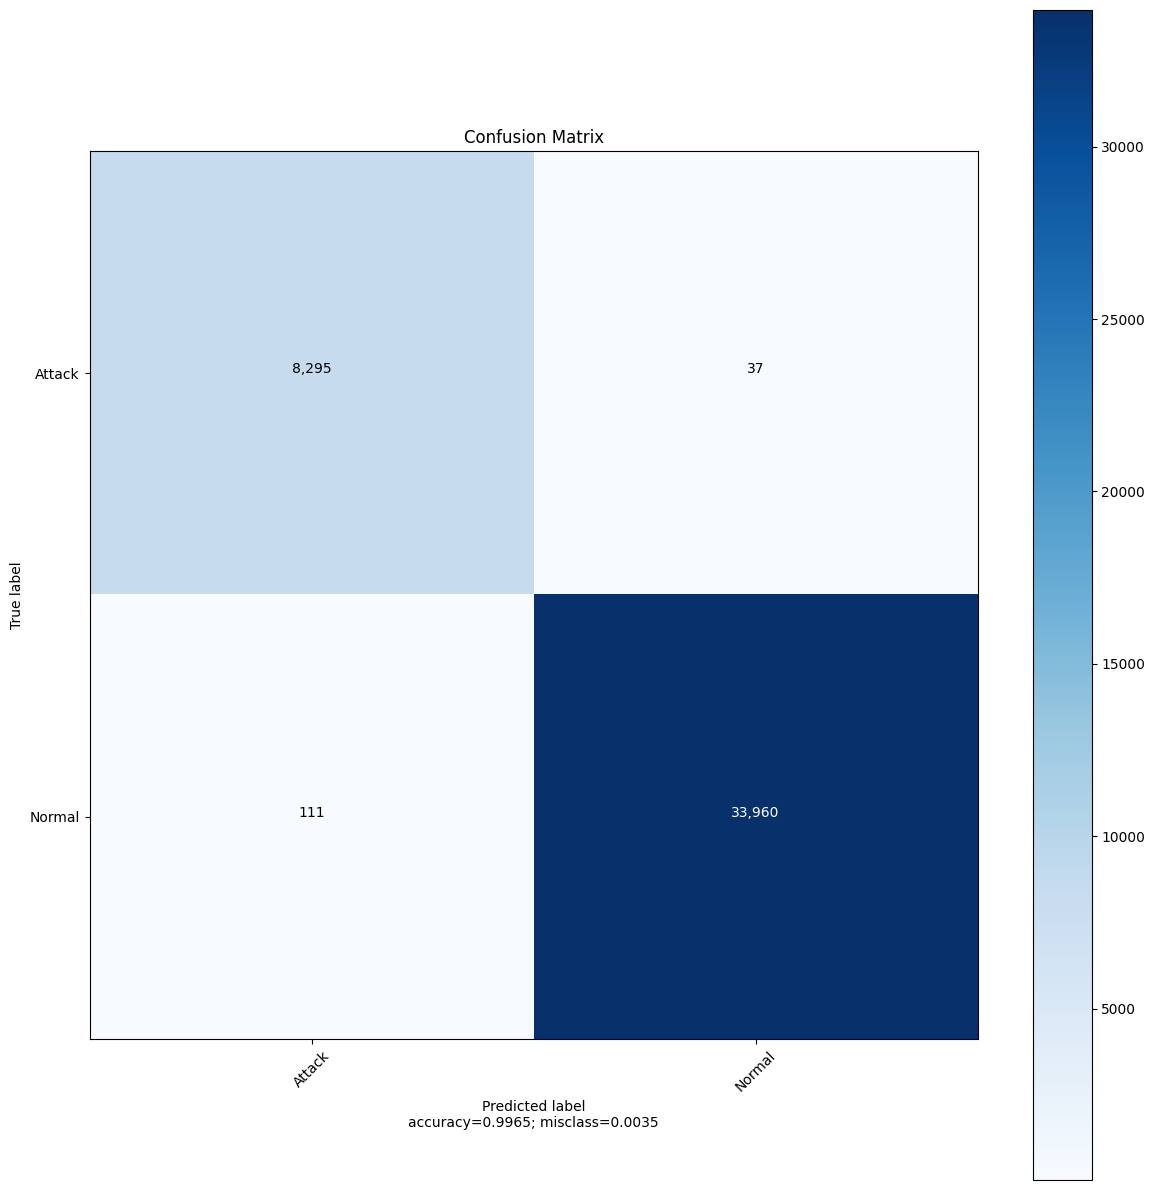

In [35]:
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [36]:
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9868    0.9956    0.9912      8332
      Normal     0.9989    0.9967    0.9978     34071

    accuracy                         0.9965     42403
   macro avg     0.9929    0.9962    0.9945     42403
weighted avg     0.9965    0.9965    0.9965     42403

